In [2]:
import pandas as pd
import numpy as np

import requests
import openpyxl as xl
import time
import json

import folium
import re

import geopandas as gpd
from matplotlib import pyplot as plt # 그래프 그리는 용도
import seaborn as sns
import geopandas as gpd
from plotnine import *
from shapely.geometry import Point, Polygon

import warnings
warnings.filterwarnings(action='ignore') # 경고메세지 숨기기

In [3]:
import matplotlib as mpl
import matplotlib.font_manager as fm  # 폰트 관련 용도

fm.get_fontconfig_fonts()
path = 'C:/Users/ajm10/AppData/Local/Microsoft/Windows/Fonts/NanumGothicEco.ttf' 

font_name=fm.FontProperties(fname=path).get_name()
plt.rc('font', family=font_name)

<br>

In [15]:
df = pd.read_excel("fin_dataset_goo.xlsx")

In [16]:
df.head(5)

,goo_nm,goo_area,sum_pop,sum_hh,one_hh,one_ratio,cc_value,count_zero,count_market,count_univ,count_bus,count_station,sum_bus,sum_station,sum_order,sum_waste
0,강남구,39.51,544055,208833,58663,0.107825,457,0,46,1,552,22,102636377,107653238,68999,5556.9
1,강동구,24.58,463998,177148,39486,0.085100,414,3,21,0,396,10,34783737,34193728,50316,2766.3
2,강북구,23.60,311569,129805,32979,0.105848,320,0,17,0,412,11,57437812,25855961,45685,838.3
3,강서구,41.44,585901,244097,69879,0.119268,548,1,22,2,619,16,55236175,43691763,86172,4928.8
4,관악구,29.57,509803,248959,115556,0.226668,460,2,24,1,490,6,89607537,61049638,129233,1631.4


In [17]:
df.shape

(25, 16)

In [23]:
df.columns

Index(['goo_nm', 'goo_area', 'sum_pop', 'sum_hh', 'one_hh', 'one_ratio',
       'cc_value', 'count_zero', 'count_market', 'count_univ', 'count_bus',
       'count_station', 'sum_bus', 'sum_station', 'sum_order', 'sum_waste'],
      dtype='object')

- 지역구 정보 : 지역구ID, 지역구 좌표계, goo_area (추가확인)

<br>

- 거주 인구 : ratio_pop(sum_hh, one_hh), sum_pop
- 유동 인구 : count_bus, sum_bus, count_station, sum_station   

<br>

- 상권 확인 : cc_value, count_market, count_univ

<br>

- 쓰레기 및 환경 : sum_order, sum_waste

<br>


- count_zero 

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   goo_nm         25 non-null     object 
 1   goo_area       25 non-null     float64
 2   sum_pop        25 non-null     int64  
 3   sum_hh         25 non-null     int64  
 4   one_hh         25 non-null     int64  
 5   one_ratio      25 non-null     float64
 6   cc_value       25 non-null     int64  
 7   count_zero     25 non-null     int64  
 8   count_market   25 non-null     int64  
 9   count_univ     25 non-null     int64  
 10  count_bus      25 non-null     int64  
 11  count_station  25 non-null     int64  
 12  sum_bus        25 non-null     int64  
 13  sum_station    25 non-null     int64  
 14  sum_order      25 non-null     int64  
 15  sum_waste      25 non-null     float64
dtypes: float64(3), int64(12), object(1)
memory usage: 3.2+ KB


In [19]:
df.describe()

,goo_area,sum_pop,sum_hh,one_hh,one_ratio,cc_value,count_zero,count_market,count_univ,count_bus,count_station,sum_bus,sum_station,sum_order,sum_waste
count,25.00000,25.000000,25.000000,25.00000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,2.500000e+01,2.500000e+01,25.00000,25.000000
mean,24.20920,396443.520000,159291.600000,45238.48000,0.116497,291.960000,1.840000,23.160000,2.320000,445.000000,11.240000,5.836599e+07,4.571766e+07,55628.04000,2089.936000
std,9.19015,126718.526659,50859.718893,19533.99439,0.033620,140.984479,1.518771,9.719739,2.230844,108.617832,4.675111,1.699460e+07,2.295111e+07,21245.60661,1314.221654
min,9.96000,134635.000000,55093.000000,18292.00000,0.062451,39.000000,0.000000,11.000000,0.000000,213.000000,3.000000,3.278296e+07,1.664897e+07,22818.00000,782.800000
25%,18.20000,322952.000000,129805.000000,34714.00000,0.091060,168.000000,1.000000,18.000000,1.000000,366.000000,8.000000,4.539694e+07,2.890679e+07,42585.00000,1206.000000
50%,23.53000,401572.000000,162391.000000,40963.00000,0.117216,305.000000,2.000000,22.000000,2.000000,450.000000,10.000000,6.026235e+07,4.094596e+07,56438.00000,1584.900000
75%,29.57000,463998.000000,179660.000000,54100.00000,0.134917,414.000000,3.000000,25.000000,3.000000,505.000000,14.000000,6.657688e+07,5.921158e+07,63172.00000,2378.100000
max,46.05000,673926.000000,255766.000000,115556.00000,0.226668,548.000000,6.000000,54.000000,9.000000,636.000000,23.000000,1.026364e+08,1.076532e+08,129233.00000,5556.900000


# 구별 상관관계 파악 

In [20]:
sample = df.copy()

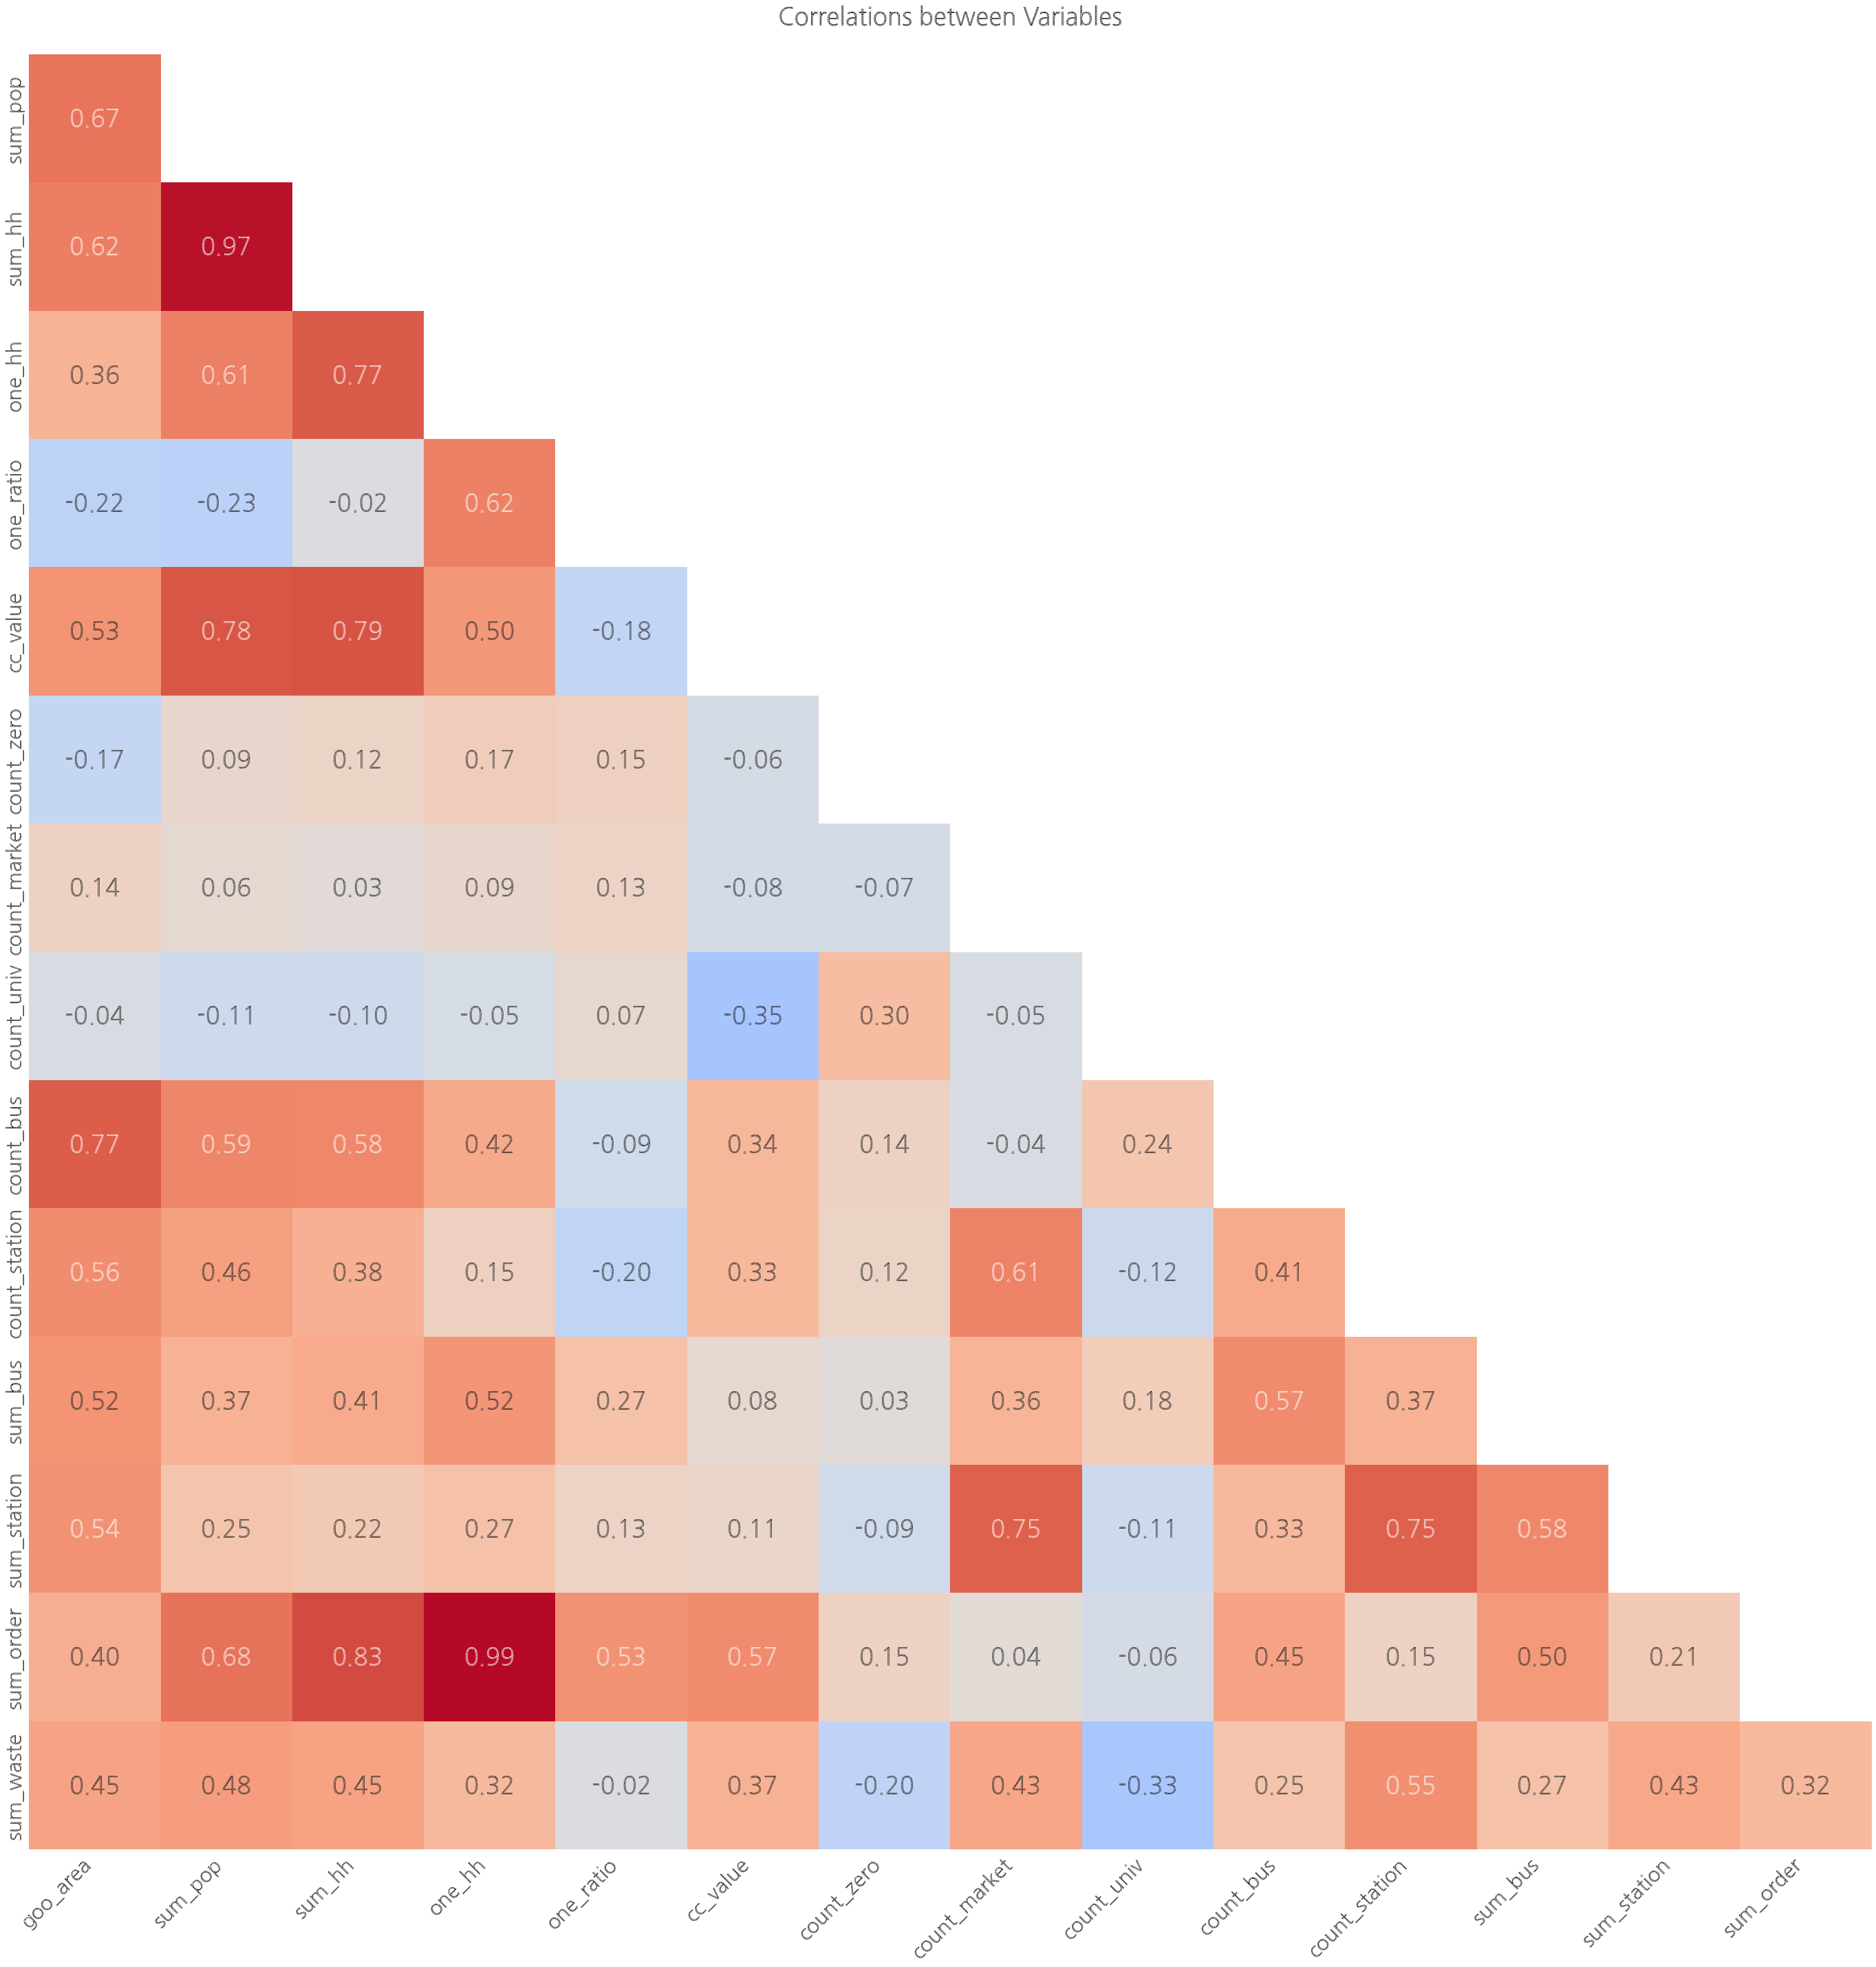

In [21]:
%matplotlib inline
corr=sample.drop(columns=['goo_nm']).corr()
mask=np.triu(np.ones_like(corr, dtype=bool))[1:,:-1]
corr=corr.iloc[1:,:-1].copy()
fig, ax = plt.subplots(figsize=(48,48))   
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, annot=True, fmt='.2f', 
            cmap='coolwarm', annot_kws={'fontsize':35,'fontweight':'bold'}, cbar=False)
ax.tick_params(left=False,bottom=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=30)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=30)
plt.title('Correlations between Variables\n', fontsize=35)
fig.show()

In [22]:
corr=sample.drop(columns=['goo_nm']).corr()
s = corr.unstack()

 # 상관계수의 절댓값 크기순으로 정렬
y = pd.DataFrame(s[s < 1].abs().sort_values(ascending=False), columns=['corr'])  
y = y[y['corr'] >= 0.4]
y.style.background_gradient(cmap='viridis') 

# seaborn

<AxesSubplot:xlabel='goo_nm', ylabel='sum_waste'>

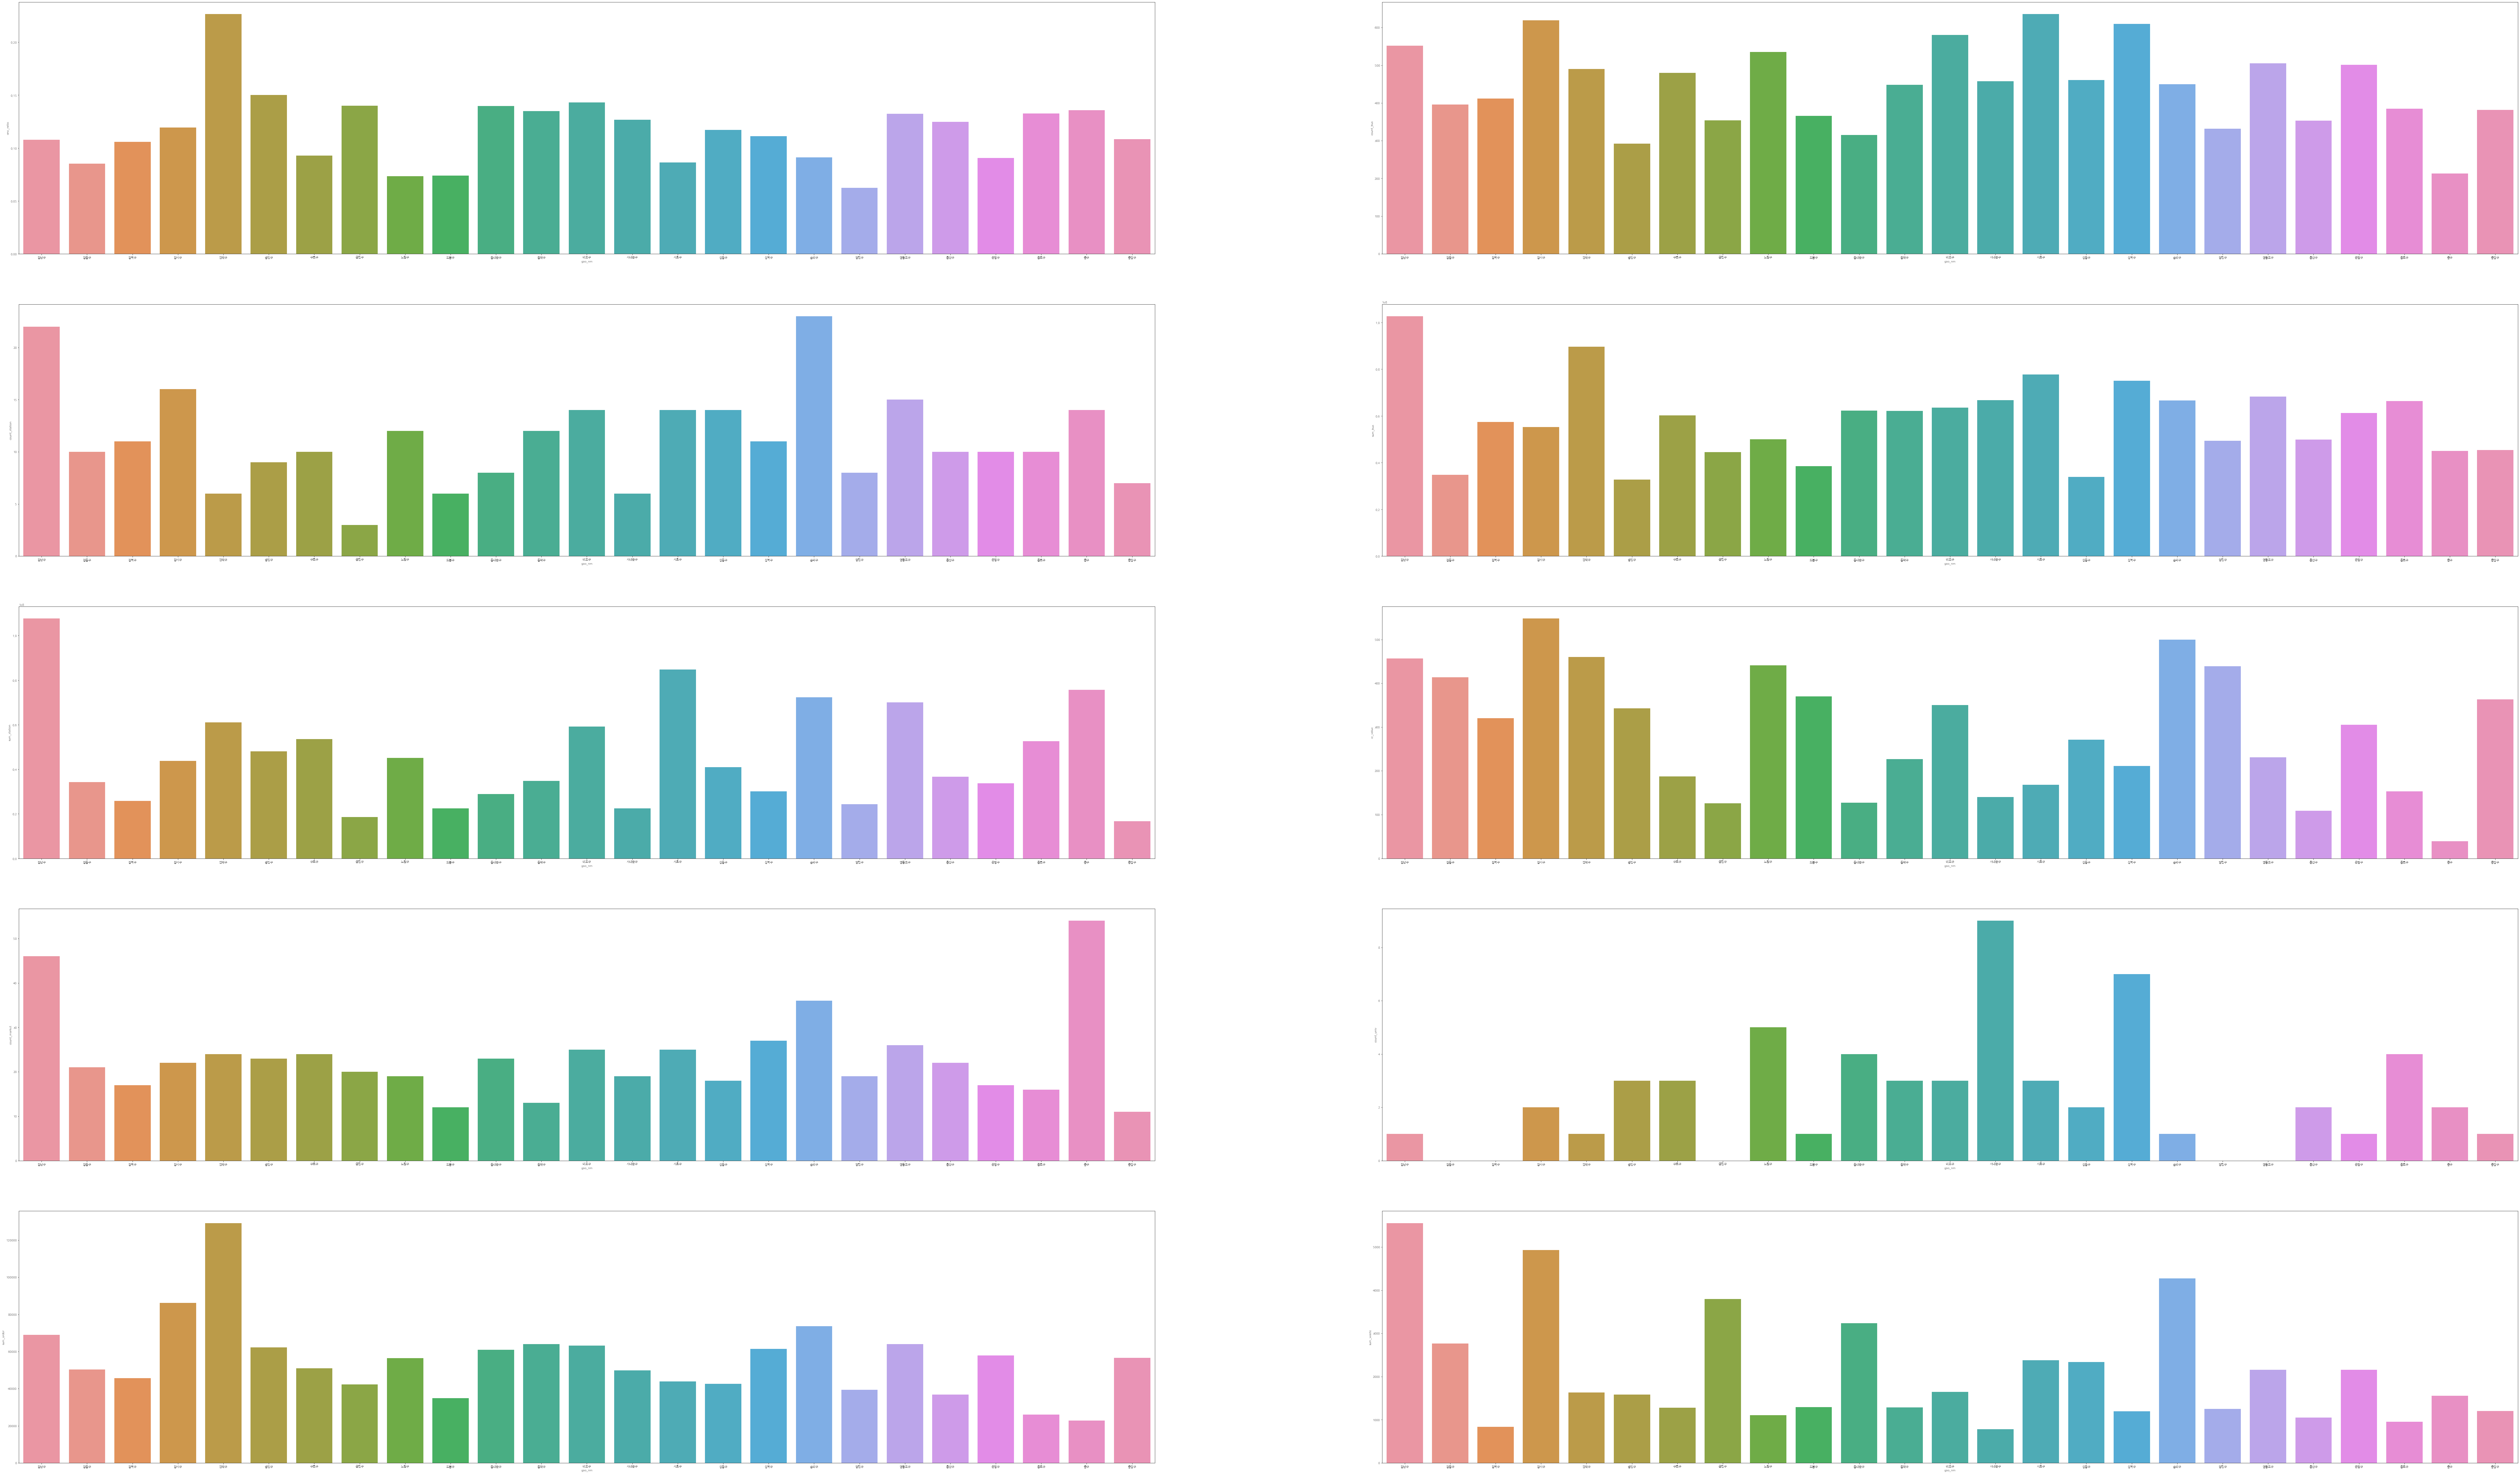

In [26]:
# 구별에 대한 각 컬럼별 데이터 분석 

figure, ((ax1,ax2), (ax3,ax4),(ax5,ax6),(ax7,ax8),(ax9,ax10) ) = plt.subplots(nrows=5, ncols=2)
figure.set_size_inches(150,90)

sns.barplot(data=df, x="goo_nm", y="one_ratio", ax=ax1) # 지역구별 1인 가구 비율 

sns.barplot(data=df, x="goo_nm", y="count_bus", ax=ax2)  # 지역구별 버스정류장 개수
sns.barplot(data=df, x="goo_nm", y="count_station", ax=ax3) # 지역구별 지하철역 개수
sns.barplot(data=df, x="goo_nm", y="sum_bus", ax=ax4)  # 지역구별 버스정류장 승하차
sns.barplot(data=df, x="goo_nm", y="sum_station", ax=ax5) # 지역구별 지하철역 하차


sns.barplot(data=df, x="goo_nm", y="cc_value", ax=ax6) # 지역구별 상권변화지수
sns.barplot(data=df, x="goo_nm", y="count_market", ax=ax7) # 지역구별 대규모점포 개수
sns.barplot(data=df, x="goo_nm", y="count_univ", ax=ax8) # 지역구별 대학교 개수

sns.barplot(data=df, x="goo_nm", y="sum_order", ax=ax9) # 지역구별 배달음식 주문량
sns.barplot(data=df, x="goo_nm", y="sum_waste", ax=ax10) # 지역구별 쓰레기 배출량

###  유동인구

In [27]:
df_cb = df[["goo_nm","count_bus"]]
df_sb = df[["goo_nm","sum_bus"]]
df_cs = df[["goo_nm","count_station"]]
df_ss = df[["goo_nm","sum_station"]]

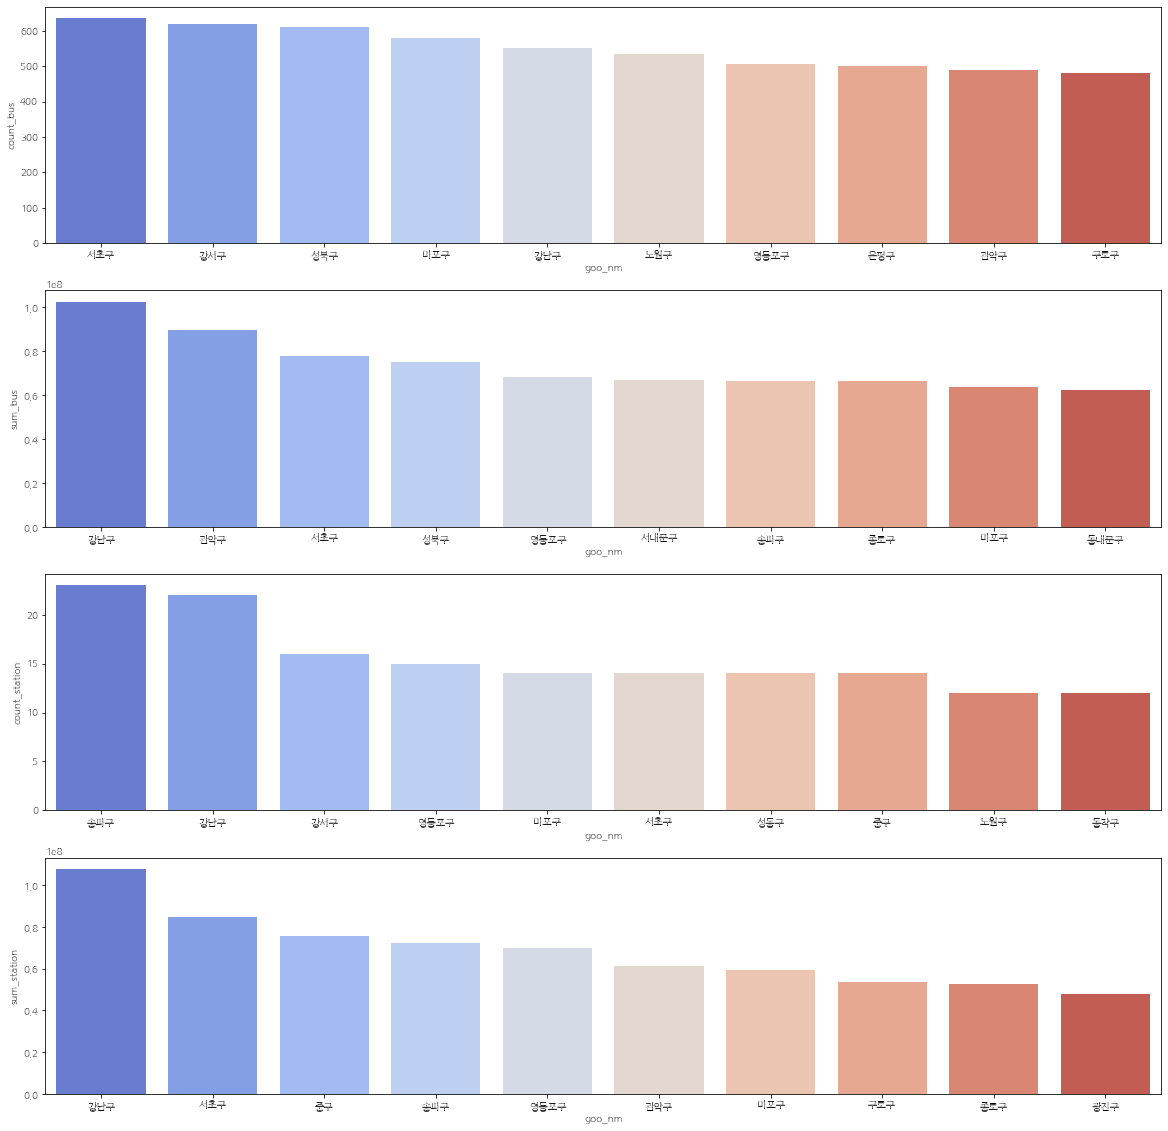

In [28]:
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(411)
ax1 = sns.barplot(x='goo_nm', y='count_bus', data=df_cb.nlargest(10, 'count_bus'), palette='coolwarm')  #값이 높은 n번째까지 출력
ax1.set_title('')

ax2 = fig.add_subplot(412)
ax2 = sns.barplot(x='goo_nm', y='sum_bus', data=df_sb.nlargest(10, 'sum_bus'), palette='coolwarm')
ax2.set_title('')

ax3 = fig.add_subplot(413)
ax3 = sns.barplot(x='goo_nm', y='count_station', data=df_cs.nlargest(10, 'count_station'), palette='coolwarm')
ax3.set_title('')

ax4 = fig.add_subplot(414)
ax4 = sns.barplot(x='goo_nm', y='sum_station', data=df_ss.nlargest(10, 'sum_station'), palette='coolwarm')
ax4.set_title('')
plt.show()

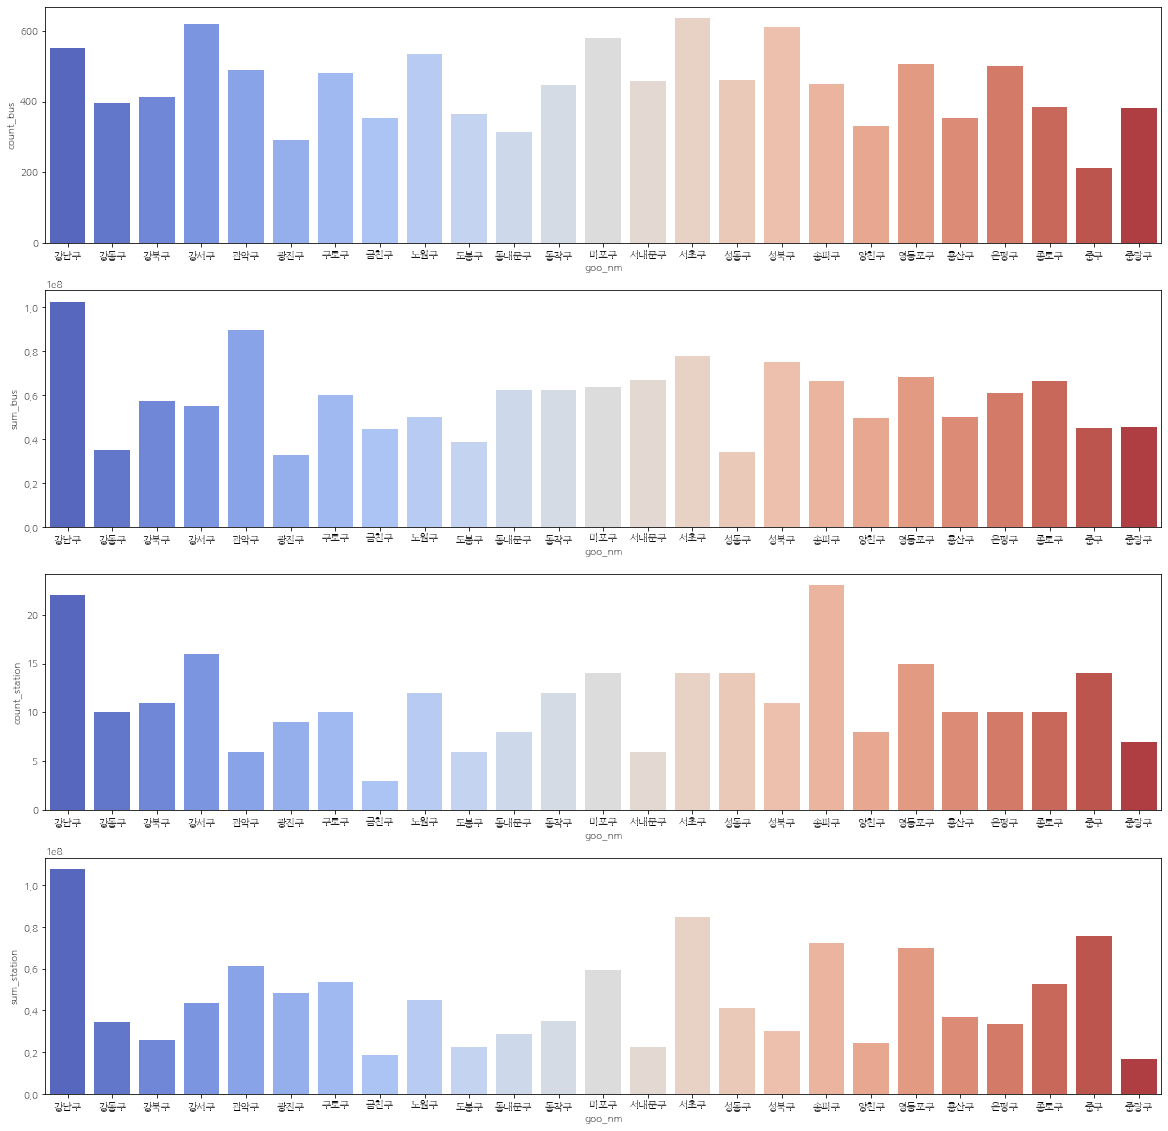

In [29]:
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(411)
ax1 = sns.barplot(x='goo_nm', y='count_bus', data=df_cb, palette='coolwarm')  
ax1.set_title('')

ax2 = fig.add_subplot(412)
ax2 = sns.barplot(x='goo_nm', y='sum_bus', data=df_sb, palette='coolwarm')
ax2.set_title('')

ax3 = fig.add_subplot(413)
ax3 = sns.barplot(x='goo_nm', y='count_station', data=df_cs, palette='coolwarm')
ax3.set_title('')

ax4 = fig.add_subplot(414)
ax4 = sns.barplot(x='goo_nm', y='sum_station', data=df_ss, palette='coolwarm')
ax4.set_title('')

plt.rc('axes', labelsize=15) # x,y 축 lable 폰트 크기
plt.rc('ytick', labelsize=18) # y축 눈금 폰트 크기 
plt.rc('xtick', labelsize=14) # x축 눈금 폰트 크기 
plt.show()

### 거주 인구

In [34]:
df_r = df[["goo_nm","one_ratio"]]

Text(0.5, 1.0, '')

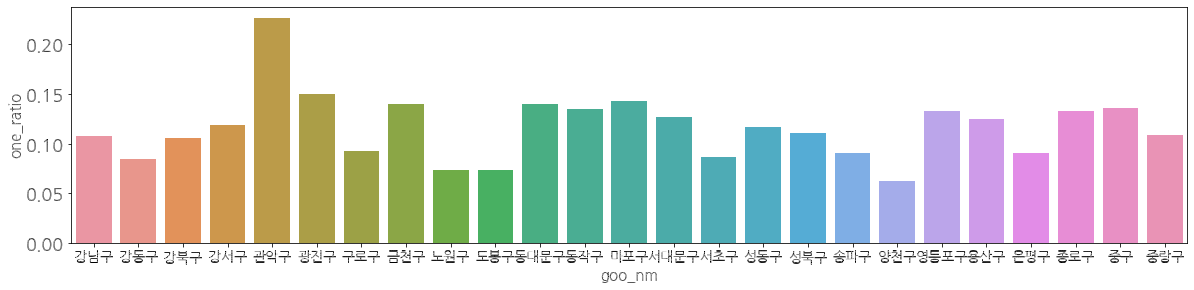

In [36]:
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(411)
ax1 = sns.barplot(x='goo_nm', y='one_ratio', data=df_r)
ax1.set_title('')

### 상권확인

In [37]:
df.head(1)

,goo_nm,goo_area,sum_pop,sum_hh,one_hh,one_ratio,cc_value,count_zero,count_market,count_univ,count_bus,count_station,sum_bus,sum_station,sum_order,sum_waste
0,강남구,39.51,544055,208833,58663,0.107825,457,0,46,1,552,22,102636377,107653238,68999,5556.9


In [38]:
df_ps = df[["goo_nm","cc_value","count_market","count_univ"]]

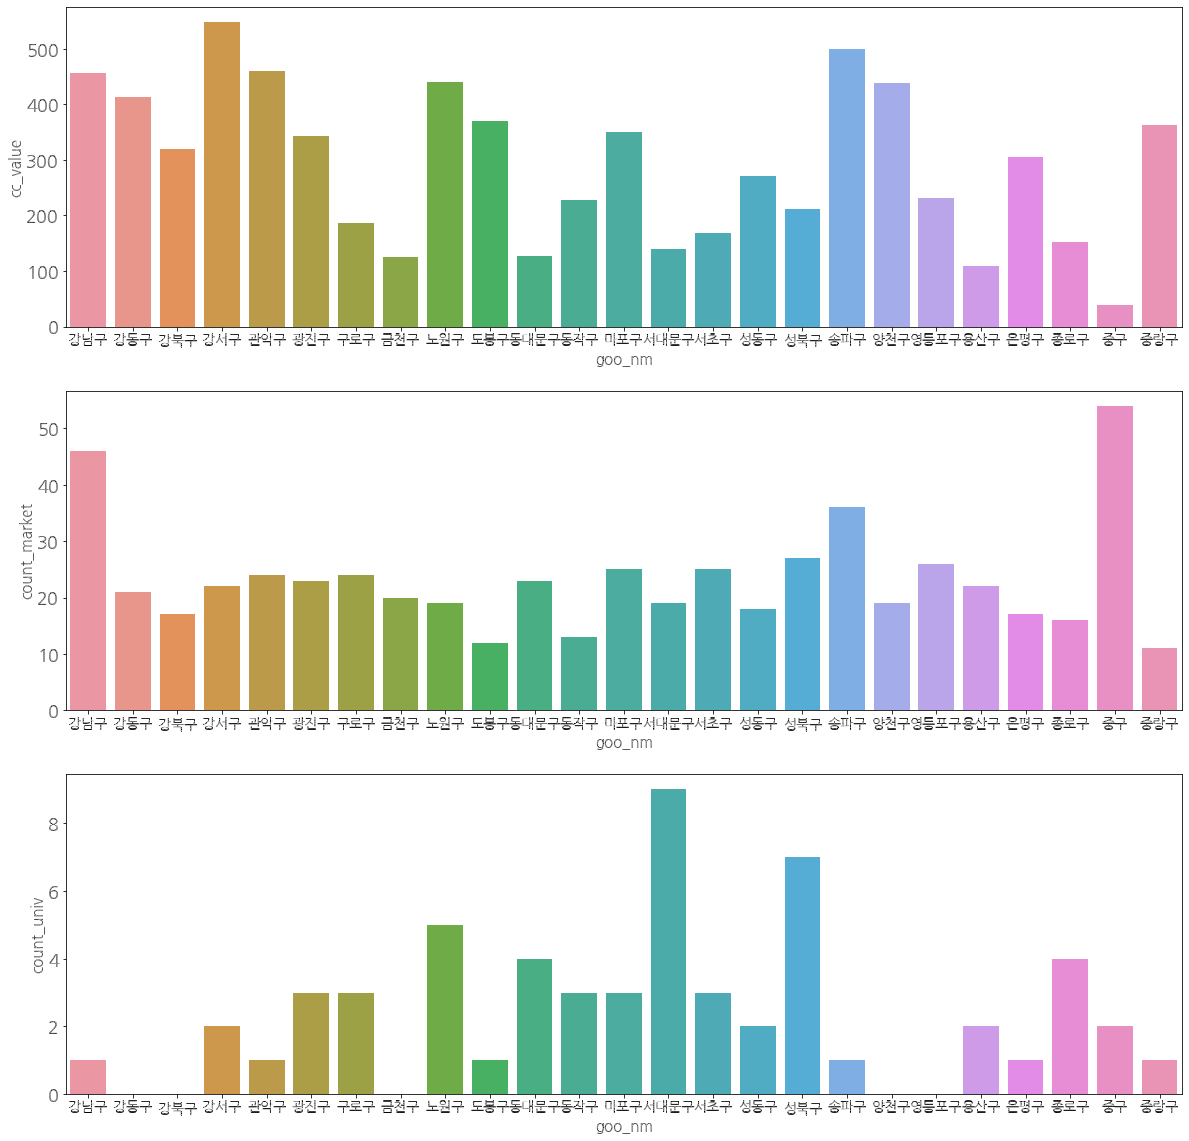

In [39]:
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(311)
ax1 = sns.barplot(x='goo_nm', y='cc_value', data=df_ps)  
ax1.set_title('')

ax2 = fig.add_subplot(312)
ax2 = sns.barplot(x='goo_nm', y='count_market', data=df_ps)
ax2.set_title('')

ax3 = fig.add_subplot(313)
ax3 = sns.barplot(x='goo_nm', y='count_univ', data=df_ps)
ax3.set_title('')

plt.rc('axes', labelsize=15) # x,y 축 lable 폰트 크기
plt.rc('ytick', labelsize=18) # y축 눈금 폰트 크기 
plt.rc('xtick', labelsize=14) # x축 눈금 폰트 크기 
plt.show()

# 환경변수

In [30]:
sub2 = df[["goo_nm", "sum_order", "sum_waste"]]

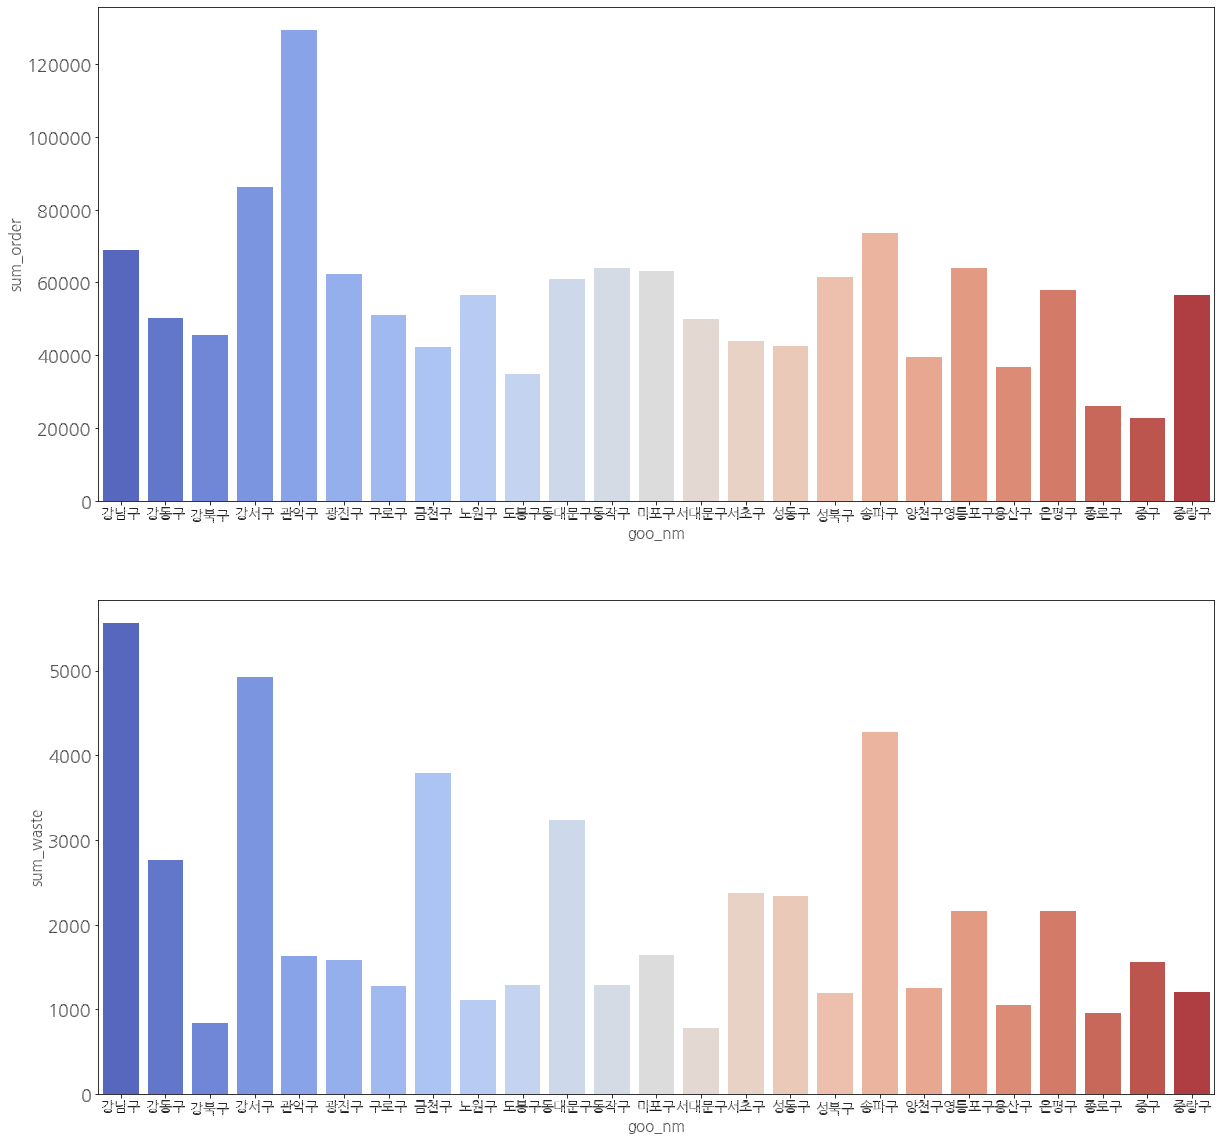

In [31]:
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(211)
ax1 = sns.barplot(x='goo_nm', y='sum_order', data=sub2, palette='coolwarm')  
ax1.set_title('')

ax2 = fig.add_subplot(212)
ax2 = sns.barplot(x='goo_nm', y='sum_waste', data=sub2, palette='coolwarm')
ax2.set_title('')

plt.rc('axes', labelsize=15) # x,y 축 lable 폰트 크기
plt.rc('ytick', labelsize=18) # y축 눈금 폰트 크기 
plt.rc('xtick', labelsize=14) # x축 눈금 폰트 크기 
plt.show()

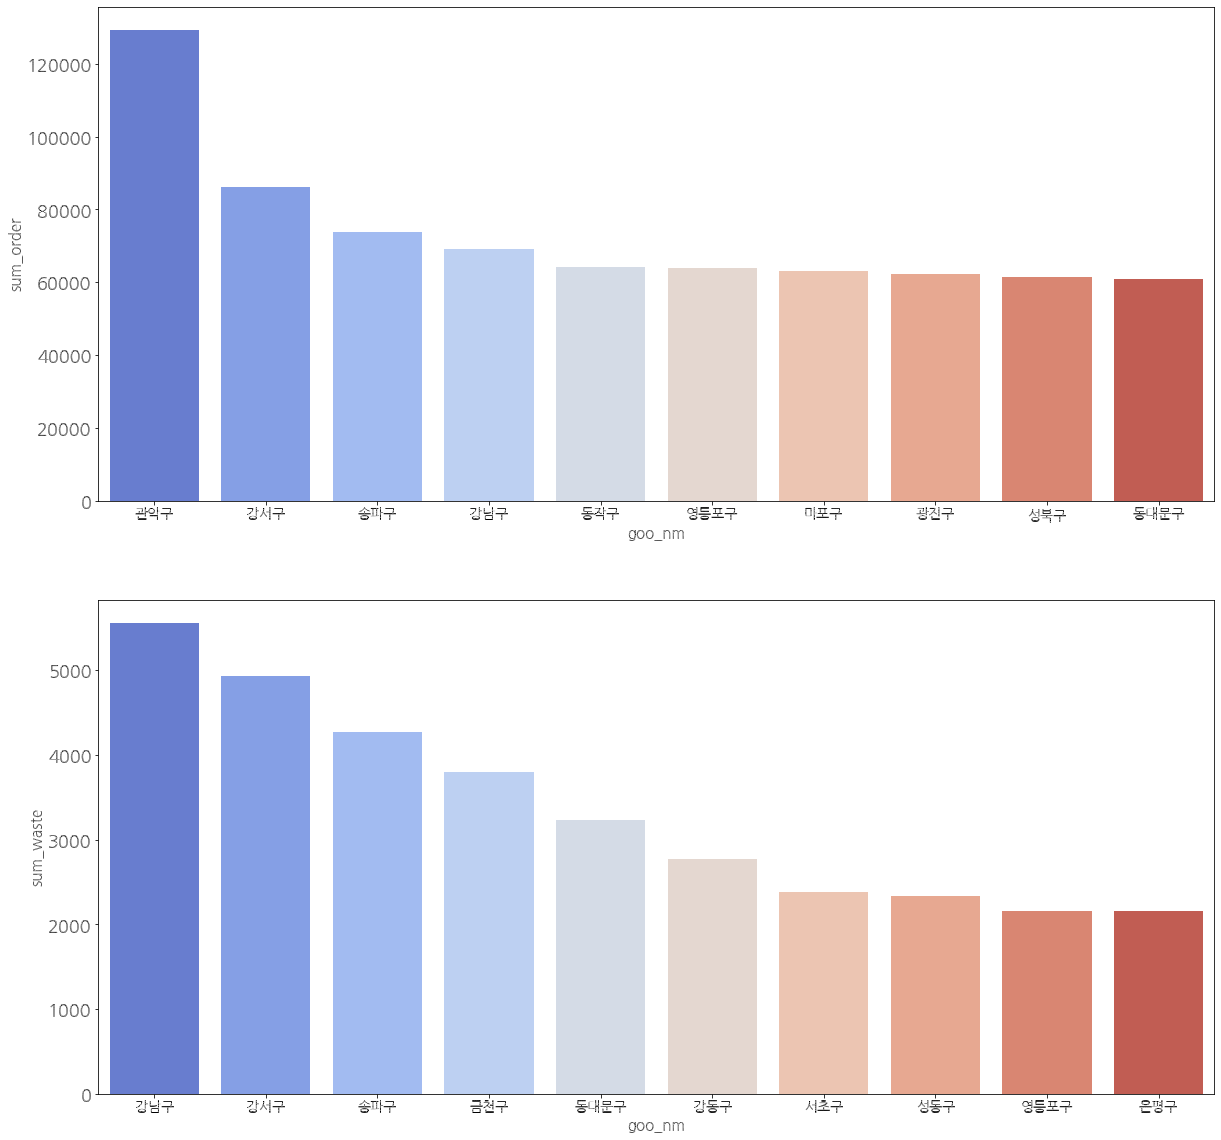

In [32]:
# data=df_cb.nlargest(10, '')

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(211)
ax1 = sns.barplot(x='goo_nm', y='sum_order', data=sub2.nlargest(10, 'sum_order'), palette='coolwarm')  
ax1.set_title('')

ax2 = fig.add_subplot(212)
ax2 = sns.barplot(x='goo_nm', y='sum_waste', data=sub2.nlargest(10, 'sum_waste'), palette='coolwarm')
ax2.set_title('')

plt.rc('axes', labelsize=15) # x,y 축 lable 폰트 크기
plt.rc('ytick', labelsize=18) # y축 눈금 폰트 크기 
plt.rc('xtick', labelsize=14) # x축 눈금 폰트 크기 
plt.show()

# GGPLOT 사용

## 지역구별 전체 인구수

## 지역구별 전체 가구수

In [16]:
new_gu_pop = df[["goo_nm","sum_pop"]]

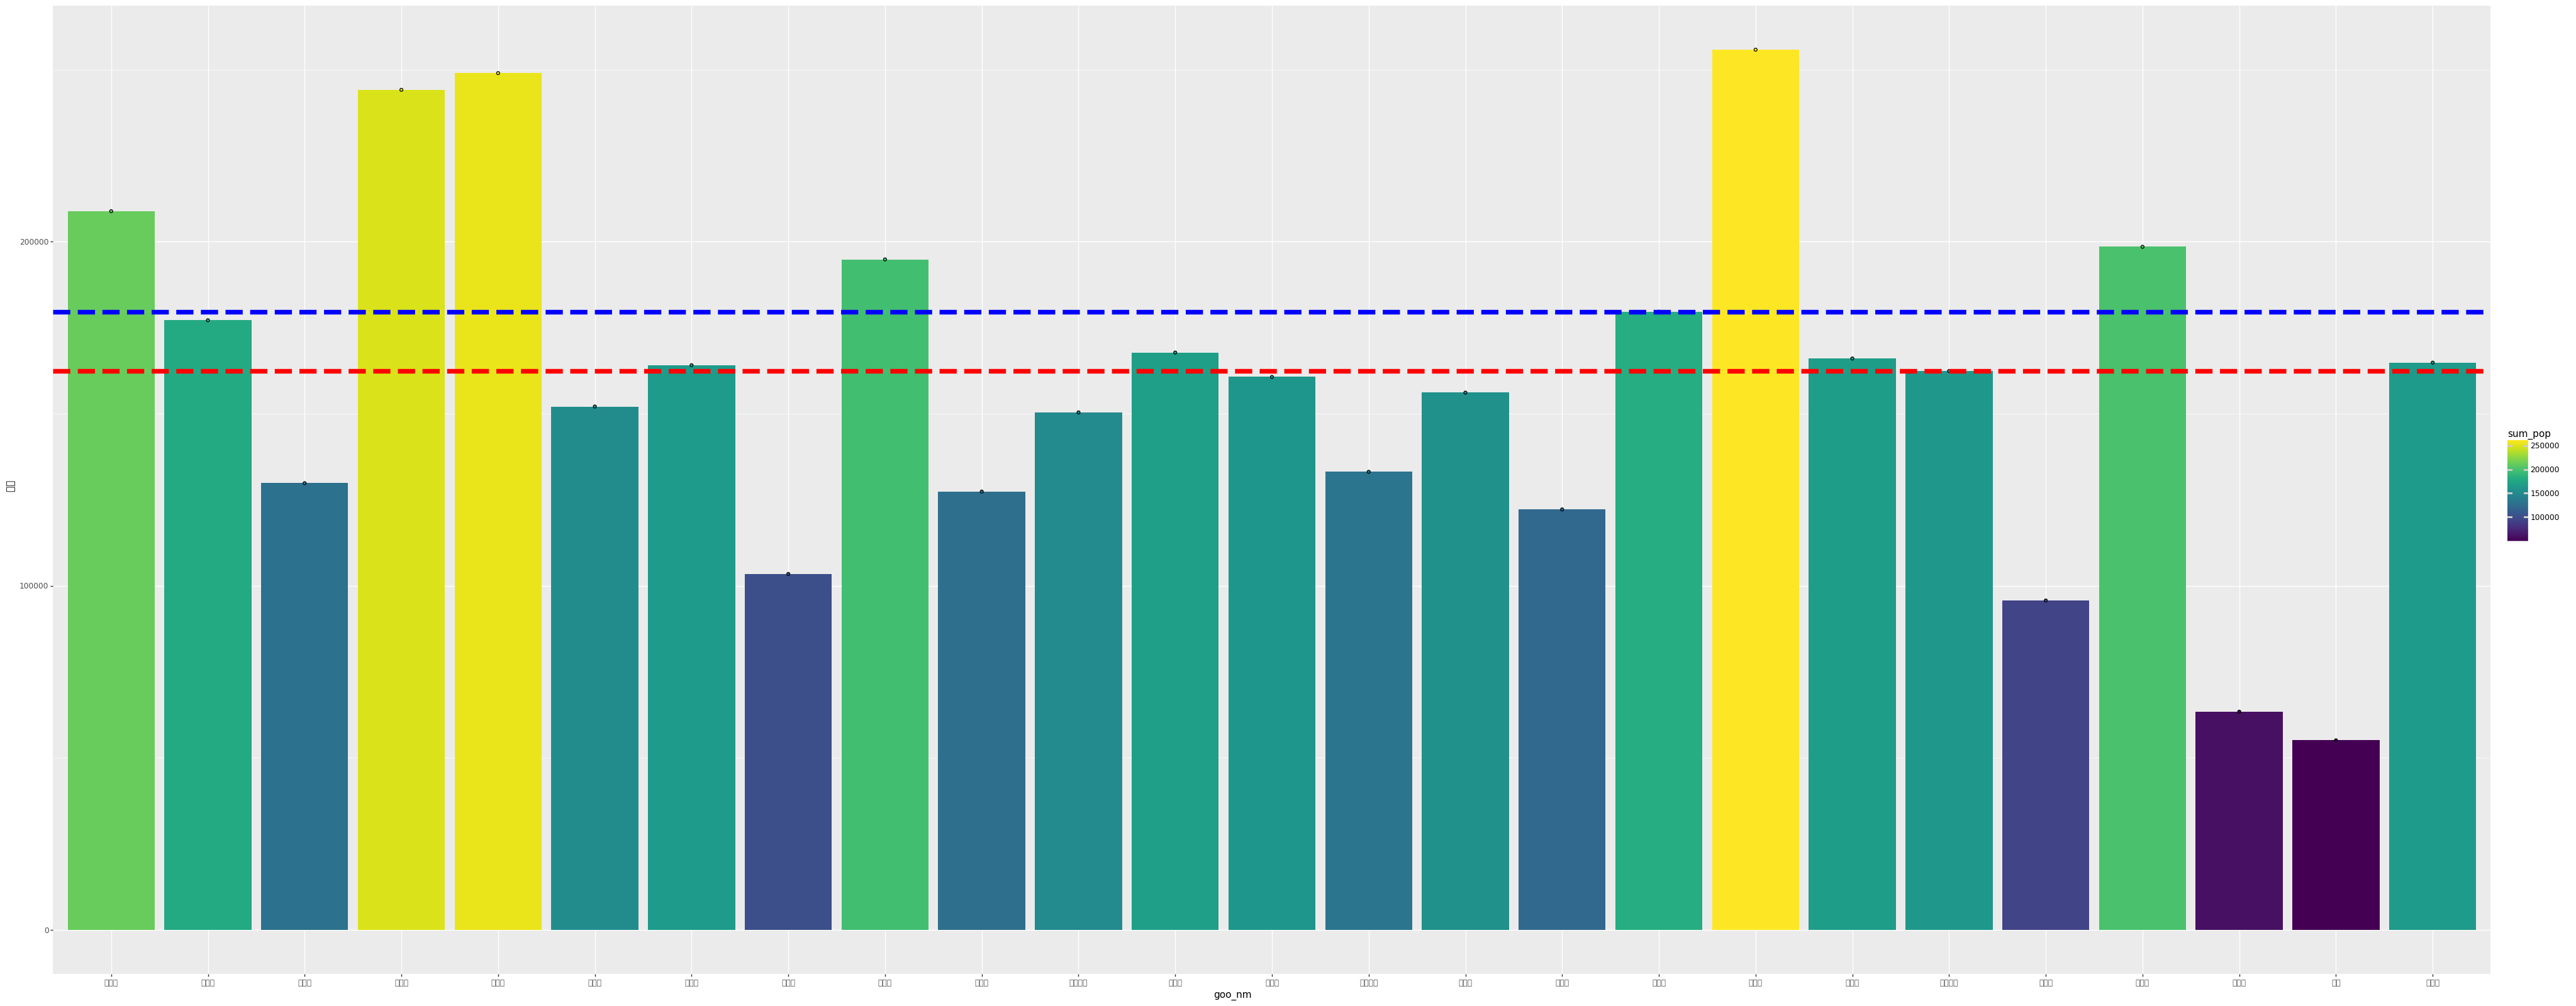

<ggplot: (119300074412)>

In [24]:
(ggplot(new_gu_pop)
+ aes(x = 'goo_nm', y = 'sum_pop', fill = 'sum_pop')
+ geom_bar(stat = 'identity')
+ geom_point()
+geom_hline(yintercept=new_gu_pop['sum_pop'].median(), linetype='dashed', color='red', size=3)
+geom_hline(yintercept=new_gu_pop['sum_pop'].quantile(0.75), linetype='dashed', color='blue', size=3)
+ labs(x='goo_nm', y='전체 ')
+ theme(text = element_text(family = "NanumBarunGothic"), figure_size = (50,20)) 
)

## 지역별 1인 가구 수

In [61]:
new_gu_pop = df[["goo_nm","one_pop"]]

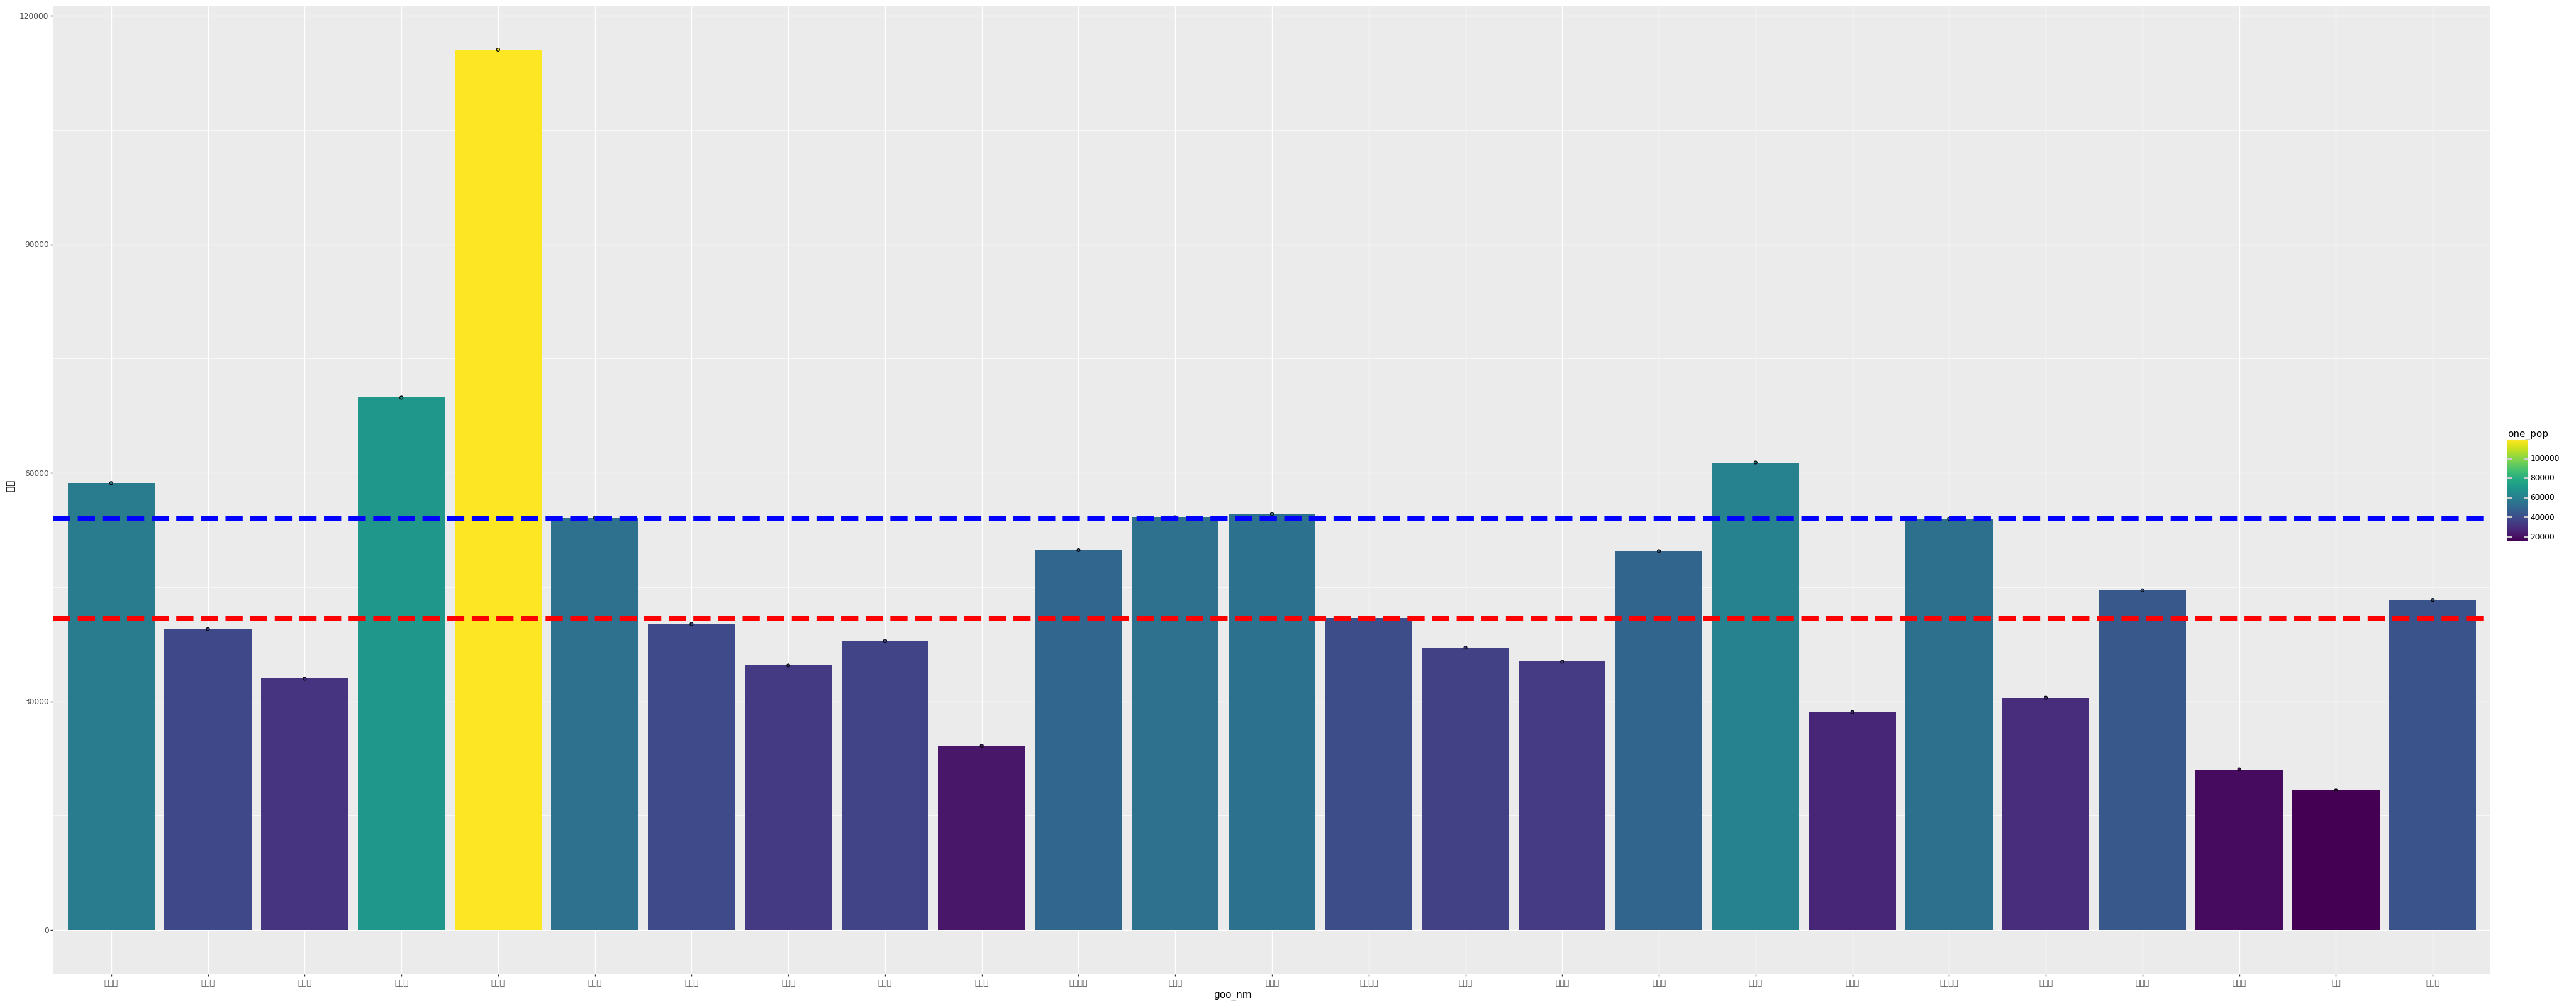

<ggplot: (119199296823)>

In [62]:
(ggplot(new_gu_pop)
+ aes(x = 'goo_nm', y = 'one_pop', fill = 'one_pop')
+ geom_bar(stat = 'identity')
+ geom_point()
+geom_hline(yintercept=new_gu_pop['one_pop'].median(), linetype='dashed', color='red', size=3)
+geom_hline(yintercept=new_gu_pop['one_pop'].quantile(0.75), linetype='dashed', color='blue', size=3)
+ labs(x='goo_nm', y='전체 ')
+ theme(text = element_text(family = "NanumBarunGothic"), figure_size = (50,20)) 
)

## 지역별 1인가구/전체가구 (ratio 사용)

In [40]:
new_gu_pop = df[["goo_nm","ratio_pop"]]

(ggplot(new_gu_pop)
+ aes(x = 'goo_nm', y = 'ratio_pop', fill = 'ratio_pop')
+ geom_bar(stat = 'identity')
+ geom_point()
+geom_hline(yintercept=new_gu_pop['ratio_pop'].median(), linetype='dashed', color='red', size=3)
+geom_hline(yintercept=new_gu_pop['ratio_pop'].quantile(0.75), linetype='dashed', color='blue', size=3)
+ labs(x='goo_nm', y='전체 ')
+ theme(text = element_text(family = "NanumBarunGothic"), figure_size = (50,20)) 
)

# 일정한 변수 추출로 df2

In [41]:
df2 = df[["goo_nm","sum_order","count_zero", "count_market", "count_bus", 
       "count_station", "sum_order", "sum_waste"]]
df2

,goo_nm,sum_order,count_zero,count_market,count_bus,count_station,sum_order,sum_waste
0,강남구,68999,0,46,552,22,68999,5556.9
1,강동구,50316,3,21,396,10,50316,2766.3
2,강북구,45685,0,17,412,11,45685,838.3
3,강서구,86172,1,22,619,16,86172,4928.8
4,관악구,129233,2,24,490,6,129233,1631.4
5,광진구,62301,1,23,292,9,62301,1584.9
6,구로구,50971,0,24,480,10,50971,1278.5
7,금천구,42334,0,20,354,3,42334,3794.8
8,노원구,56438,1,19,535,12,56438,1108.3
9,도봉구,34884,0,12,366,6,34884,1290.8


In [ ]:
# scikit-learn uses population standard deviation - 정규화 (1)
univ_norm = univ_dd.apply(preprocessing.scale, axis=0)